# Example with training, offline and on-line learning

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle

epsilon = 10e-80
vmin = -3.0

## Training parameters

In [2]:
strict_maximum = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 5

# Training protocol
training_times = 0.100
inter_pulse_intervals = 0.0
inter_sequence_interval = 1.0
resting_time = 3.0
epochs = 3

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i', 'a', 'z_pre', 'z_post']

#### Off-line training

../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


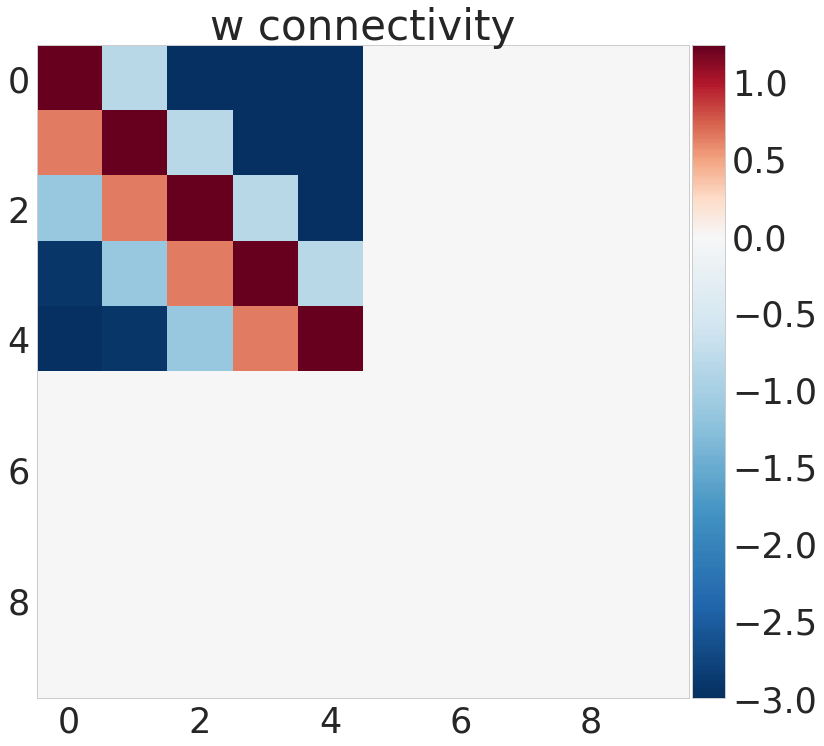

In [3]:
# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
w_off_line = np.copy(manager.nn.w)
plot_weight_matrix(manager, vmin=vmin)

#### Temporal trajectories

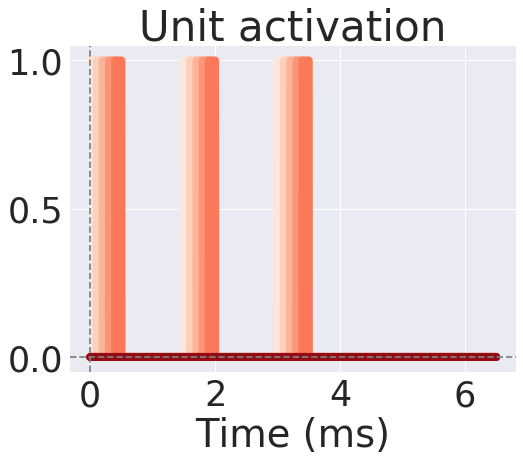

In [4]:
lw = 8
ms = 15
cm = sns.color_palette('Reds', n_colors=minicolumns)

fig = plt.figure()
ax = fig.add_subplot(111)


for index, o in enumerate(timed_input.O):
    ax.plot(manager.time, o, lw=lw, ms=ms, color=cm[index])
    
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Time (ms)')
ax.set_title('Unit activation');

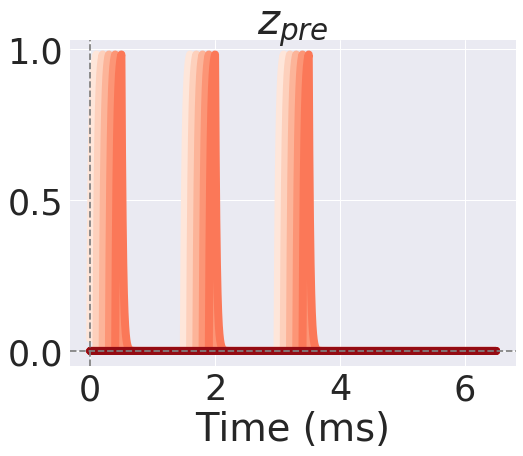

In [5]:
lw = 8
ms = 15
cm = sns.color_palette('Reds', n_colors=minicolumns)

fig = plt.figure()
ax = fig.add_subplot(111)


for index, o in enumerate(timed_input.z_pre):
    ax.plot(manager.time, o, lw=lw, ms=ms, color=cm[index])
    
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Time (ms)')
ax.set_title(r'$z_{pre}$');

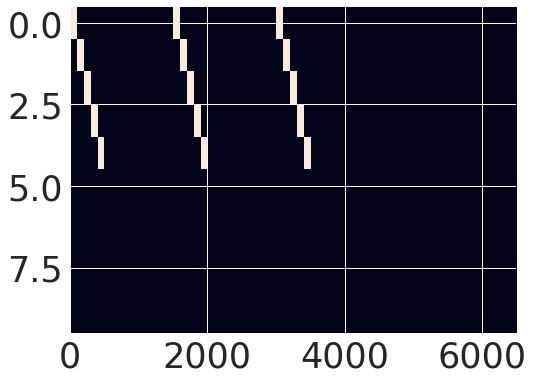

In [6]:
plt.imshow(timed_input.O, aspect='auto')

#### recall

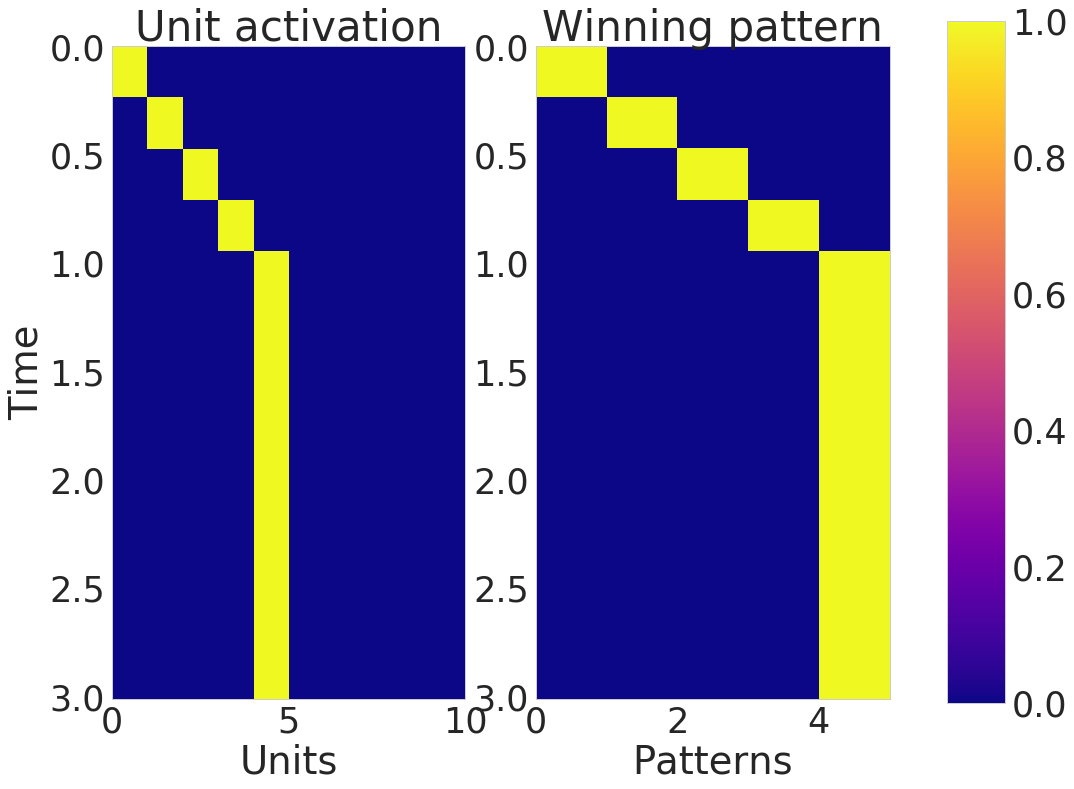

In [7]:
T_recall = 3.0
T_cue = tau_s
I_cue = 0
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=I_cue, reset=True, empty_history=True)
plot_network_activity_angle(manager)

#### Calculate persistent times

../network.py:477: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:481: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


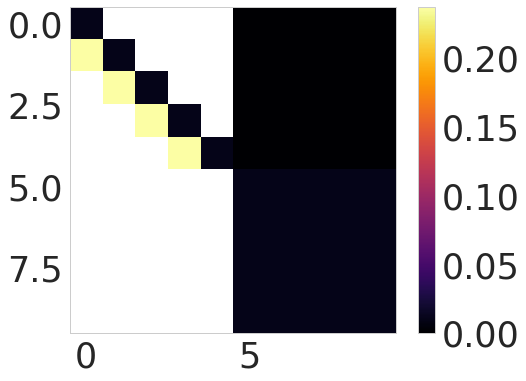

In [8]:
T_persistence = manager.calculate_persistence_time_matrix()
plt.imshow(T_persistence, cmap='inferno')
plt.colorbar()

In [9]:
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

for i in range(n_patterns - 1):
    print("calculated = {:5.4f}, simulated = {:5.4f}".format(T_persistence[i + 1, i], persistent_times[i]))

calculated = 0.2371, simulated = 0.2360
calculated = 0.2371, simulated = 0.2370
calculated = 0.2371, simulated = 0.2370
calculated = 0.2371, simulated = 0.2370


#### Test the values that are not in the main attractor

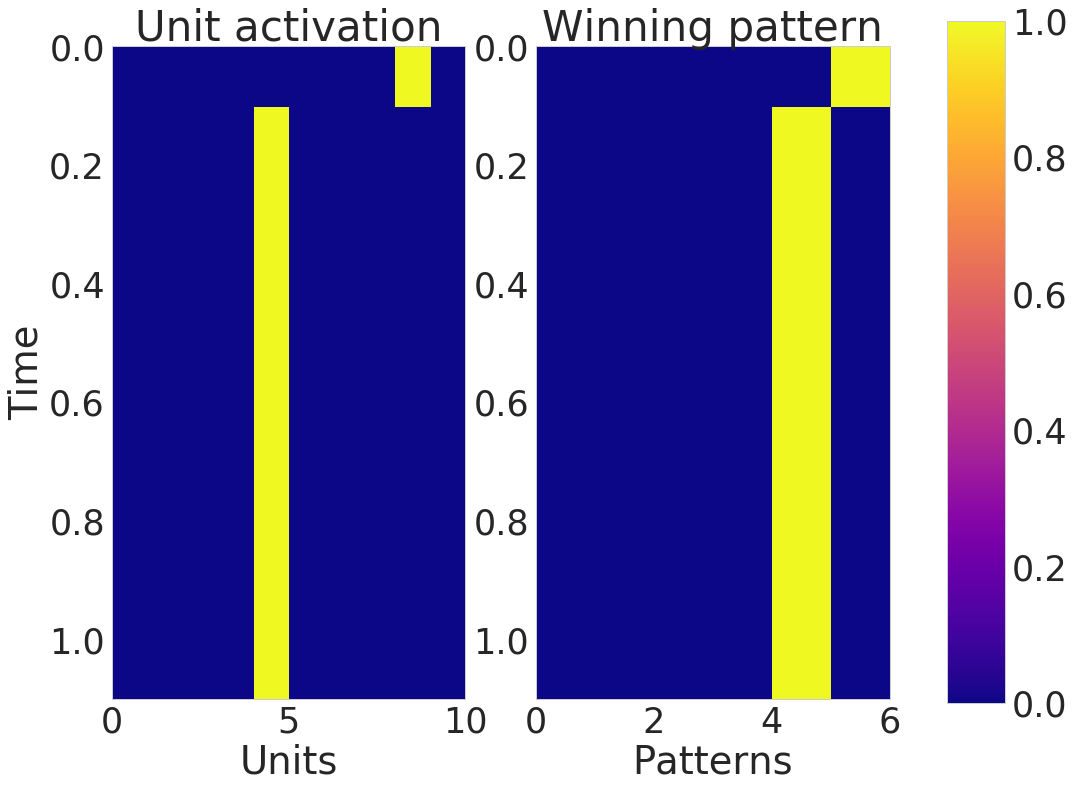

In [10]:
T_recall = 1.00
T_cue = 0.100
I_cue = manager.canonical_network_representation[8]
nn.g_I = 100.0
manager.update_patterns(I_cue[np.newaxis, :])
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=I_cue, reset=True, empty_history=True)
plot_network_activity_angle(manager)

## On-line training


../network.py:342: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:


epochs 0
epochs 1
epochs 2
CPU times: user 648 ms, sys: 0 ns, total: 648 ms
Wall time: 646 ms


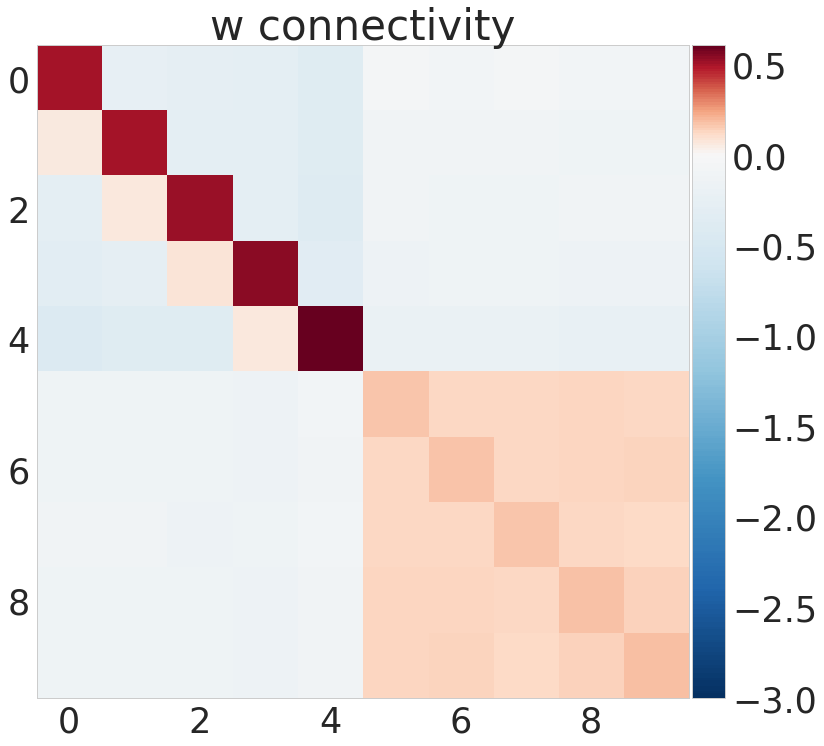

In [21]:
%%time
# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
manager.run_network_protocol(protocol)
w_normal = np.copy(manager.nn.w)
plot_weight_matrix(manager, vmin=vmin)

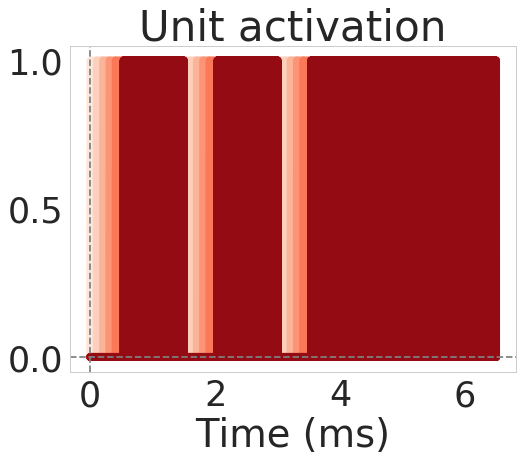

In [22]:
## lw = 8
ms = 15
cm = sns.color_palette('Reds', n_colors=minicolumns)

fig = plt.figure()
ax = fig.add_subplot(111)


for index, o in enumerate(manager.history['o'].T):
    ax.plot(manager.time, o, lw=lw, ms=ms, color=cm[index])
    
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Time (ms)')
ax.set_title('Unit activation');

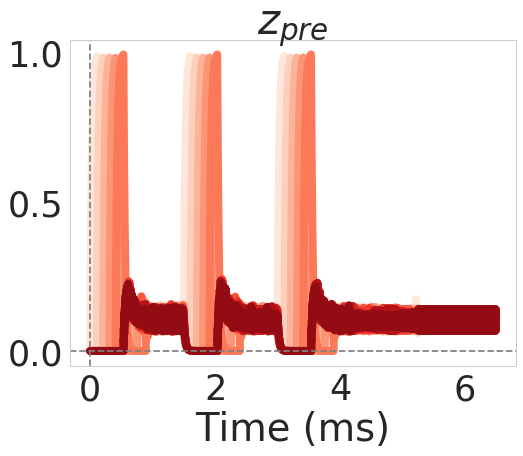

In [23]:
lw = 8
ms = 15
cm = sns.color_palette('Reds', n_colors=minicolumns)

fig = plt.figure()
ax = fig.add_subplot(111)


for index, o in enumerate(manager.history['z_pre'].T):
    ax.plot(manager.time, o, lw=lw, ms=ms, color=cm[index])
    
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Time (ms)')
ax.set_title(r'$z_{pre}$');

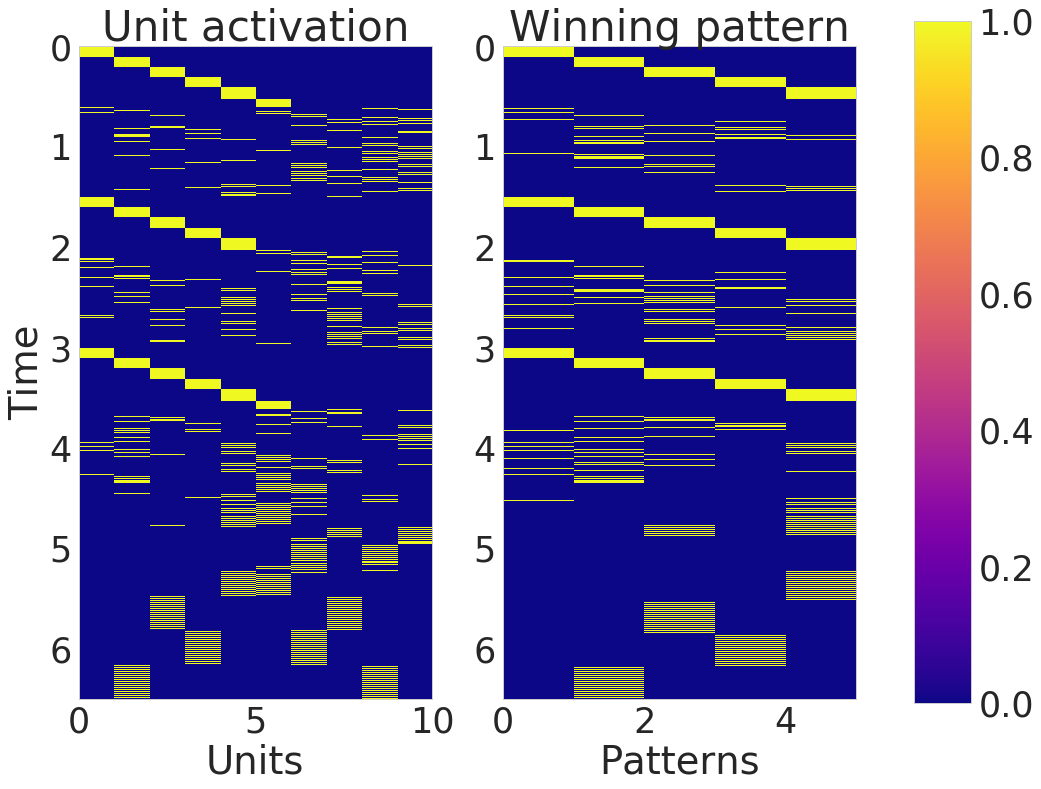

In [24]:
plot_network_activity_angle(manager, recall=False)

#### Recall

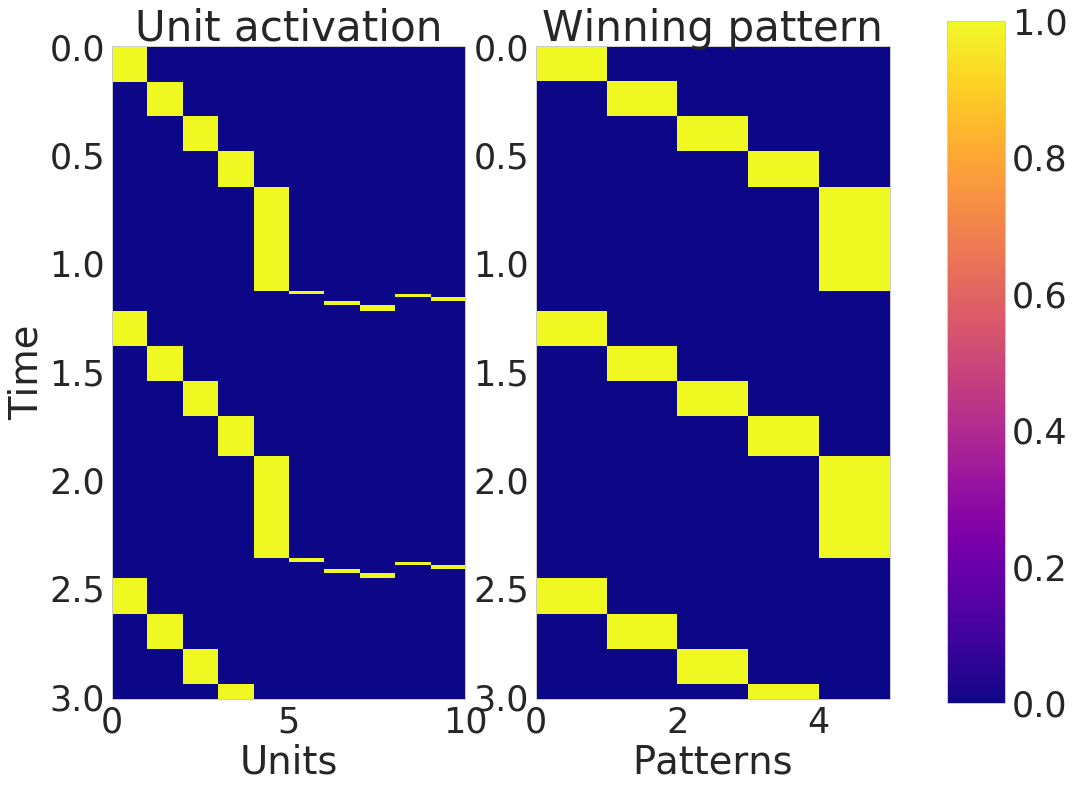

In [25]:
T_recall = 3.0
T_cue = tau_s
I_cue = 0
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=I_cue, reset=True, empty_history=True)
plot_network_activity_angle(manager)

#### Test function to calculate persistent time matrix

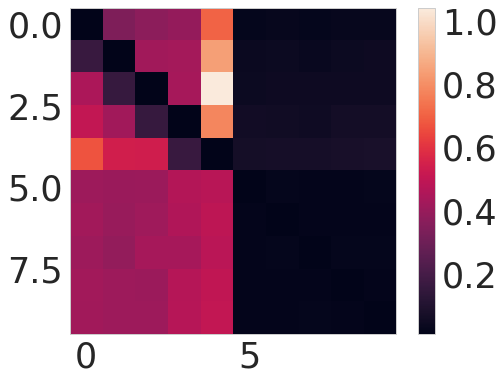

In [26]:
T_persistence = manager.calculate_persistence_time_matrix()
plt.imshow(T_persistence)
plt.colorbar()

In [27]:
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

for i in range(n_patterns - 1):
    print("calculated = {:5.4f}, simulated = {:5.4f}".format(T_persistence[i + 1, i], persistent_times[i]))

calculated = 0.1640, simulated = 0.1630
calculated = 0.1597, simulated = 0.1600
calculated = 0.1614, simulated = 0.1620
calculated = 0.1659, simulated = 0.1660


#### Test the values that are not in the main attractor

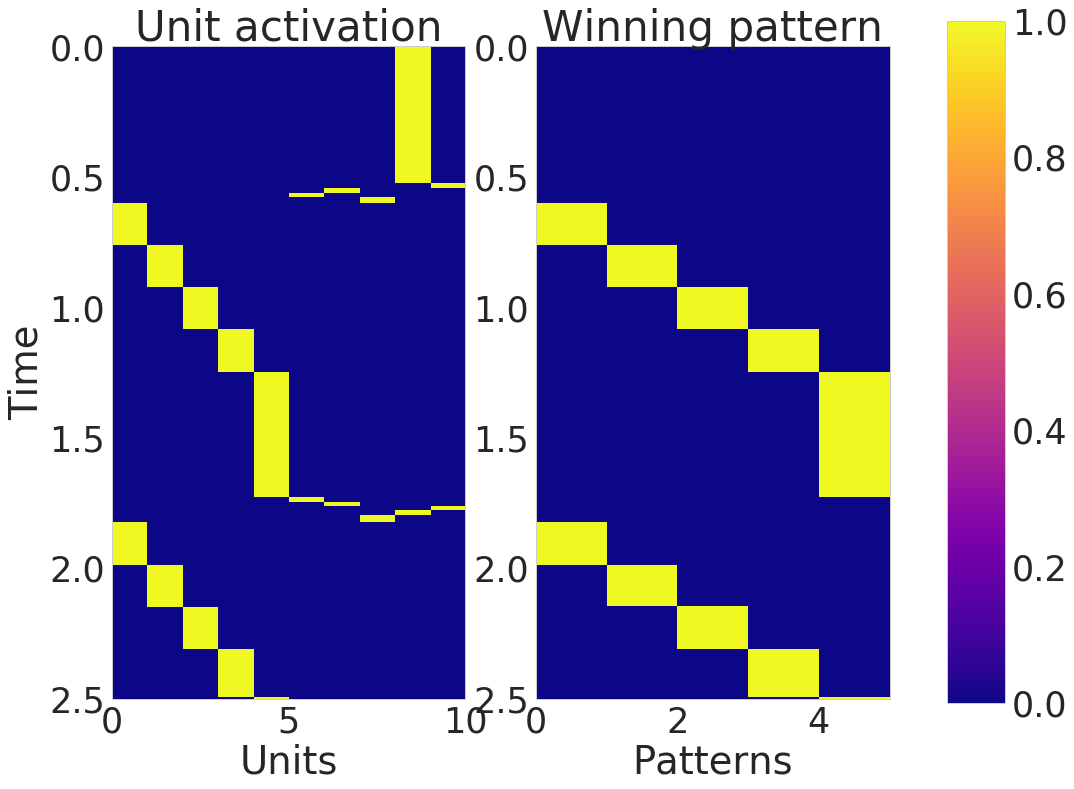

In [28]:
T_recall = 2.0
T_cue = 0.5
I_cue = manager.canonical_network_representation[8]
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=I_cue, reset=True, empty_history=True)
plot_network_activity_angle(manager)